In [1]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import os
import sys
import pickle as pkl
import ast
import pandas as pd
import random
import json 
import pickle
from tqdm import tqdm
from scipy.sparse import lil_matrix
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
import math
import scanpy as sc
import anndata as ad
from scipy import stats
import squidpy as sq
import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyArrowPatch, ArrowStyle
torch.backends.cudnn.enable =True
torch.backends.cudnn.benchmark = True
import warnings
warnings.filterwarnings('ignore')  # Disable all warnings

In [2]:
import RegChat

# Load data

In [3]:
path = '/Users/lihuazhang/Documents/projects/RegChat/RegChat_code/Dataset/MISAR_db/'
signaling_pathway = pd.read_csv(path + 'database.csv')

In [4]:
adata_rna = ad.read_h5ad(path+"E15_5-S1_expr_gt.h5ad")

In [5]:
# remove duplicate genes
gene_names = adata_rna.var_names.to_list()
# Find duplicates
duplicates = pd.Series(gene_names).duplicated(keep='first')
# Filter AnnData to keep only first occurrence
adata_rna = adata_rna[:, ~duplicates].copy()

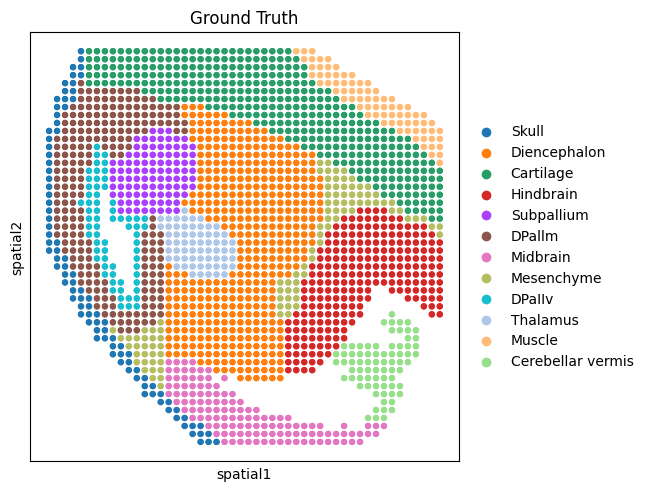

In [6]:
sq.pl.spatial_scatter(
    adata_rna,
    shape=None,
    color='Ground Truth',
    size=50
)

In [7]:
cell_type = adata_rna.obs['Ground Truth']

In [8]:
X = adata_rna.X
coord = pd.DataFrame(data = adata_rna.obsm['spatial'], index = cell_type.index)

In [9]:
Ls = list(set(signaling_pathway['Ligand_Symbol'].tolist()))
Rs = list(set(signaling_pathway['Receptor_Symbol'].tolist()))
TFs = list(set(signaling_pathway['TF_Symbol'].tolist()))
TGs = list(set(signaling_pathway['TG_Symbol'].tolist()))

In [10]:
TGs_u = [x for x in TGs if x not in gene_names]
TGs_u

['H1f5', 'Septin9', 'Septin6']

In [11]:
# remove the links in pathway
signaling_pathway = signaling_pathway[~signaling_pathway['TG_Symbol'].isin(TGs_u)]

In [12]:
TGs = list(set(signaling_pathway['TG_Symbol'].tolist()))
TGs_u = [x for x in TGs if x not in gene_names]
TGs_u

[]

In [13]:
signaling_pathway.index = pd.RangeIndex(start=0, stop=len(signaling_pathway), step=1)

In [14]:
counts_type = cell_type.value_counts(dropna=False)
print(counts_type)

Ground Truth
Diencephalon         438
Cartilage            364
Hindbrain            236
DPallm               223
Midbrain             123
Mesenchyme            99
Subpallium            97
Skull                 93
Muscle                75
Cerebellar vermis     73
DPaIIv                65
Thalamus              63
Name: count, dtype: int64


In [15]:
adata_rna.obs['cell_type'] = adata_rna.obs['Ground Truth']

In [16]:
# export spa loc
spa = adata_rna.obsm['spatial']
spa_df = pd.DataFrame(data = spa, index = adata_rna.obs_names, columns = ['x','y'])

In [18]:
# add ref to label
from RegChat import model
adata_rna_final = model.label_to_int(adata_rna)

In [19]:
spot_loc = pd.DataFrame(data = adata_rna_final.obsm['spatial'], index = adata_rna_final.obs.index, columns = ['x','y'])

In [20]:
gene_cell_pd = pd.DataFrame(data = adata_rna_final.X.T.toarray())
gene_cell_pd.index = adata_rna_final.var.index
gene_cell_pd.columns = adata_rna_final.obs.index

In [21]:
from RegChat import Train_CCC_model

In [23]:
result_LR, result_LRFG, result_LG, h, score_l_record, score_g_record,tfg_l, CCI_strength_pd, LRFG_strength_pd, LG_strength_pd, CCI_score_pd, LRFG_score_pd,LRF_score_pd, LG_score_pd, nei_adj = Train_CCC_model(adata_rna = adata_rna_final, links_database = signaling_pathway, gene_cell_pd =gene_cell_pd,spot_loc=spot_loc, hidden_dim = 1, attn_drop = 0.0, layers_hidden=10, tau = 0.8, locMeasure='euclidean', lamb_1=1, lamb_2=1, lamb_3=1, mode = 'fast', no_label = False, no_spatial = False, neig_number=10, pure_cutoff = 0.1, sub_epochs=200, per_num_cut = None, epochs=500, lr=0.0001, weight_decay=0, use_cuda=0)

spot location for adjancy
Size of CCC pairs: 173
Start model training
10 cost: 8.129063 relative decrease ratio: 0.0020921794
20 cost: 7.9741745 relative decrease ratio: 0.0017818996
30 cost: 7.843461 relative decrease ratio: 0.0015440957
40 cost: 7.733379 relative decrease ratio: 0.0012873348
50 cost: 7.6408687 relative decrease ratio: 0.0011378656
60 cost: 7.56086 relative decrease ratio: 0.0009809196
70 cost: 7.4988213 relative decrease ratio: 0.0007261592
80 cost: 7.45247 relative decrease ratio: 0.0005574996
90 cost: 7.4139276 relative decrease ratio: 0.0004858672
100 cost: 7.38019 relative decrease ratio: 0.00043237972
110 cost: 7.3501196 relative decrease ratio: 0.0003911714
120 cost: 7.322711 relative decrease ratio: 0.0003591897
130 cost: 7.297622 relative decrease ratio: 0.00033045313
140 cost: 7.2748437 relative decrease ratio: 0.0002958528
150 cost: 7.2553797 relative decrease ratio: 0.0002446884
160 cost: 7.239545 relative decrease ratio: 0.00019953302
170 cost: 7.2265034 

# plot the communication stength

In [24]:
from RegChat import utils

In [25]:
x_lr = utils.neg_log10_transform(CCI_strength_pd.to_numpy(), replace_zero=1e-12)

In [26]:
var_lr = pd.DataFrame({
    'gene_name': CCI_strength_pd.columns
}, index=CCI_strength_pd.columns)
adata_rna_lr = ad.AnnData(X=x_lr, var=var_lr)
adata_rna_lr.obsm = adata_rna_final.obsm

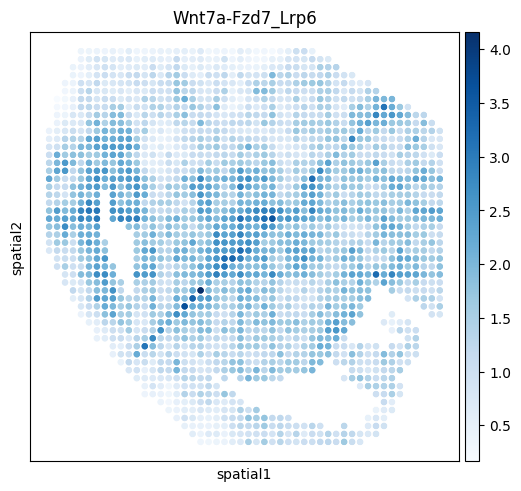

In [33]:
sq.pl.spatial_scatter(
    adata_rna_lr,
    shape=None,
    color=['Wnt7a-Fzd7_Lrp6'],
    size=50,
    cmap = 'Blues'
)

# plot the direction only for the significant spots for focused metapath

In [28]:
from RegChat import analysis

In [31]:
adata_rna_final.X = adata_rna_final.X.todense().copy()

In [42]:
p_val_cutoff = 0.01
res_df = analysis.get_signifcant_node(adata_rna_final,result_LR, nei_adj,spot_loc,p_val_cutoff,type = 'mix',topk = 2)

In [34]:
label_list = ['DPaIIv','DPallm','Skull','Subpallium','Diencephalon','Thalamus','Mesenchyme','Midbrain','Hindbrain','Cartilage','Muscle','Cerebellar vermis']

In [35]:
color_map = {
    'DPaIIv': '#1FBFD0',       # 蓝色
    'DPallm':'#8D574C',  # 橙色
    'Skull': '#2278B5',  # 绿色
    'Subpallium': '#855AA5',     # 蓝色
    'Diencephalon':'#F57F20',
    'Thalamus': '#AEC7E8',  # 橙色
    'Mesenchyme': '#B6BE62',  # 绿色
    'Midbrain': '#D87AB2',  # 橙色
    'Hindbrain': '#B6BE62',
    'Cartilage':'#279E69',
    'Muscle':'#FCBB78',
    'Cerebellar vermis':'#9ED08A'  
}
coord_df = coord.copy()
cell_type = adata_rna_final.obs['cell_type']

In [36]:
cell_type = cell_type.astype(str)

In [37]:
coord_df['color'] = cell_type.map(color_map)

In [40]:
coord_df.columns = ["x","y","color"]

Text(0.5, 1.0, 'Communication Direction under: Wnt7a-Fzd7_Lrp6')

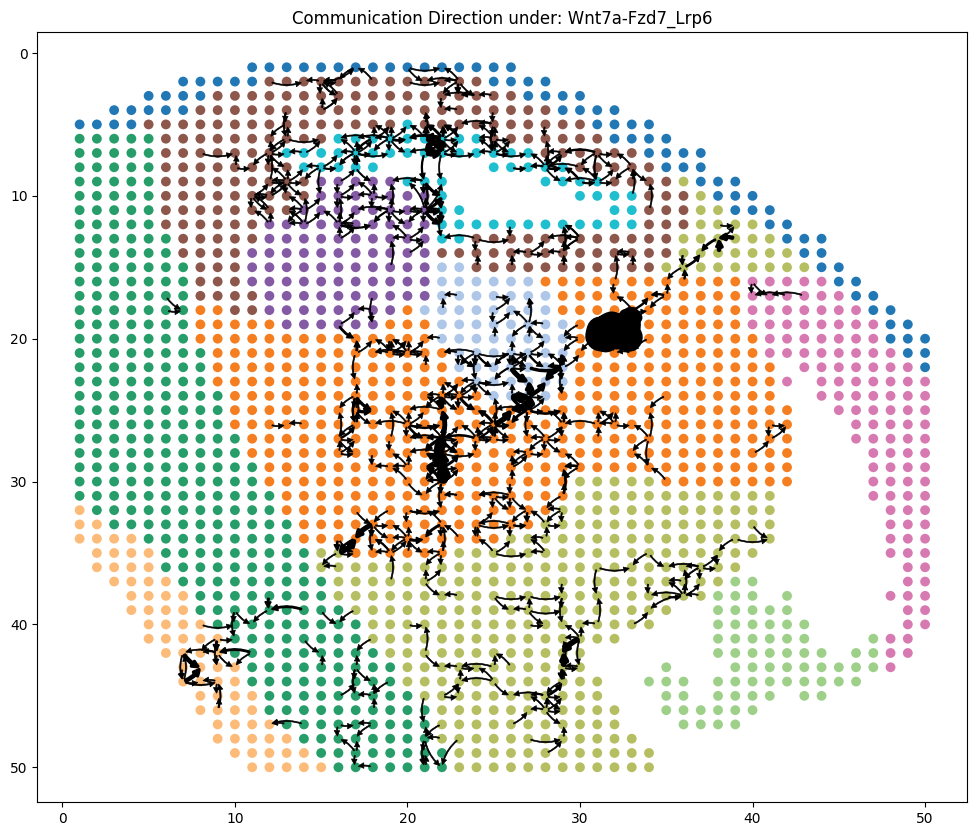

In [44]:
res_specific_df = res_df[res_df['LR_Name'].str.contains("Wnt7a-Fzd7_Lrp6")]
plt.figure(figsize=(12, 10))
scatter = plt.scatter(coord_df['y'], coord_df['x'],
                     c=coord_df['color'].tolist(), alpha=1, s=50, linewidths=0) 
plt.gca().invert_yaxis() 
for index, row in res_specific_df.iterrows():
    strength = row['Comm_Score']
    lw = max(0.5, strength*0.1)
    arrowstyle = ArrowStyle("Simple", head_length=0.5, head_width=0.5, tail_width=0.1)
    arrow = FancyArrowPatch((row['Sender_y'],row['Sender_x']), 
                            (row['Receiver_y'], row['Receiver_x']),
                            connectionstyle="arc3,rad=0.2", 
                            arrowstyle=arrowstyle, color='black', lw=lw,
                            mutation_scale=8)
    plt.gca().add_patch(arrow)
    
handles = [plt.Line2D([0], [0], marker='o', color='w', label=celltype, markerfacecolor=color, markersize=1)
           for celltype, color in color_map.items()]
plt.title('Communication Direction under: '+ "Wnt7a-Fzd7_Lrp6")